In [3]:
# standard lib
import os
from pathlib import Path
from typing import Optional, Dict

# scientific libs
import numpy as np
import pandas as pd

# DL libs
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import esm
from esm.data import ESMStructuralSplitDataset
from sklearn.metrics import roc_auc_score

# graph libs
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
"""Adapted from: https://github.com/facebookresearch/esm/blob/main/examples/esm_structural_dataset.ipynb"""

# Load datasets
train_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

valid_dataset = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='valid', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
)

In [5]:
# Load model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

# Freeze all parameters of the pretrained model
for param in model.parameters():
    param.requires_grad = False

In [6]:
# Prepare data, optimizer, and objective/loss function
batch_converter = alphabet.get_batch_converter()
contact_threshold = 15

In [6]:
# rand_example = np.random.randint(len(valid_dataset))
# rand_target = valid_dataset[rand_example]
# print(f"Data point {rand_example}, {rand_target['seq']}")

Data point 229, KDLTIGMSIDDLRLERWQKDRDIFVKKAESLGAKVLVQSANGDDSAQISQIENMLNKNVDVLVIIPHNGDVLSNVISEAKKEGVKVLAYDRLINNADLDFYVSFDNEKVGELQADAIIKEKPEGNYFLMGGSPVDNNAKLFRKGQMKVLQPLIDSGKIKVVGDQWVDSWLAEKALQIMENALTANKNNIDAVVASNDATAGGAIQALSAQGLSGKVAISGQDADLAAIKRIVEGTQTMTVYKPITNLADKAAELSVALGKEEKLEPNAKLNNGLKEVDAYLLDPIVVTKDNIDSTVIKDGFHSKEAVYK


In [7]:
# Fixed example to compare
rand_example = 229
rand_target = valid_dataset[rand_example]

In [8]:
batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

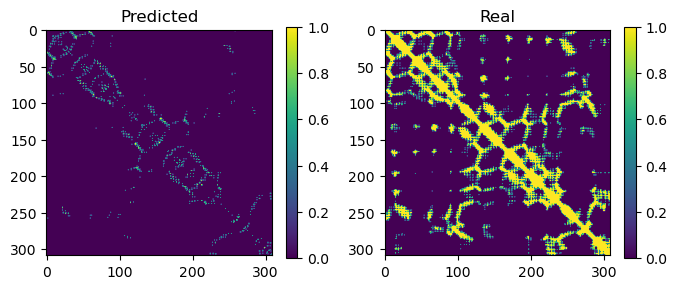

In [9]:
N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c) #['dist'] < contact_threshold)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [10]:
# Modify only the last layer for regression task
model.contact_head.regression = nn.Linear(in_features=model.contact_head.regression.in_features, out_features=1)

# Set requires_grad=True only for the regression layer parameters to be trained
for param in model.contact_head.regression.parameters():
    param.requires_grad = True

In [11]:
for param in model.contact_head.regression.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

contact_head.regression.weight
contact_head.regression.bias


In [12]:
# remove all the nans
masked_train = []
masked_valid = []

# modify dataset to remove/mask entries without any coordinates/distances
for t in train_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": "".join(c for c, cm in zip(t['seq'], mask) if cm),
        "ssp": "".join(c for c, cm in zip(t['ssp'], mask) if cm),
        "coords": t["coords"][mask],
        # Boolean values to only recognise distances up to a threshold of 15A
        "dist": mdist < contact_threshold
    }
    masked_train.append(masked_entry)
    
for t in valid_dataset:
    mask = ~np.isnan(t["coords"].sum(axis=1))
    mdist = t["dist"][mask][:, mask]
    masked_entry = {
        "seq": ''.join(c for c, cm in zip(t["seq"], mask) if cm),
        "ssp": ''.join(c for c, cm in zip(t["ssp"], mask) if cm),
        "coords": t["coords"][mask],
        "dist": mdist < contact_threshold
    }
    masked_valid.append(masked_entry)

In [15]:
device = torch.device("cpu")
# if torch.backends.cuda.is_built():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#     device = torch.device("mps")
print(f"Using device {device}")

Using device cpu


In [ ]:
# Training loop
learning_rate = 0.003

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
               
# loss is calculated for each input and target pair, mean values calculated manually
loss_fn = nn.BCELoss(reduction="none")

num_epochs = 8

print(f"Epoch\tTrain loss\tTest loss")
for epoch in range(num_epochs):
    model.train()
               
    # Initialise loss for each epoch   
    total_loss = 0
    # Number of sequences used to train model (1024/12312 samples)
    tsize = 1024
    # Training on randomly selected sequences in batches of 8
    for b in tqdm(
        DataLoader(np.random.choice(len(masked_train), size=tsize, replace=False), batch_size=8, shuffle=True),
    ncols=40):
        # Tokenise input sequences
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_train[i]["seq"]) for i in b])
        # Clear gradients for each epoch
        optimizer.zero_grad()
        # Output predictions for batch 
        outputs = model(batch_tokens.to(device), return_contacts=True)
        
        # Initialise objects to 0 to match the format of contact output tensor
        targets = torch.zeros_like(outputs["contacts"])
        mask = torch.zeros_like(outputs["contacts"])
        src_mask = torch.zeros_like(outputs["contacts"])

        # Pull masked and boolean (dist threshold) values from training sequences   
        for i_, ti in enumerate(b):
            cm = masked_train[ti]["dist"]
            N = cm.shape[0]
            targets[i_, :N, :N] = torch.tensor(cm)
            mask[i_, :N, :N] = 1
            # Short range contacts up to 12 redidues are masked
            row_up, col_up = torch.triu_indices(N, N, offset=12)
            row_low, col_low = torch.tril_indices(N, N, offset=-12)
            src_mask[i_, row_up, col_up] = 1
            src_mask[i_, row_low, col_low] = 1
            targets = targets * src_mask
            
        # Calculates bce loss between predictions and true values
        loss = loss_fn(outputs["contacts"], targets)
        # Manually calculate mean per run (reduction = "none")
        loss = (loss * mask).mean()
        # Pool loss values from each batch
        total_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Updates last layer parameters to reduce loss
        optimizer.step()
        del batch_tokens, targets, mask
    
    valid_loss = 0
    vsize = 1
    for b in DataLoader(range(vsize), batch_size=1, shuffle=True):
        batch_labels, batch_strs, batch_tokens = batch_converter([(i, masked_valid[i]["seq"]) for i in b])
        inputs = batch_tokens
        # contacts
        targets = torch.tensor(np.array([masked_valid[i]["dist"] for i in b]), dtype=torch.float32)
        outputs = model(batch_tokens.to(device), return_contacts=True)
        # Calculates loss between predictions and true values
        loss = nn.BCELoss()(outputs["contacts"], targets)
        # Pool loss values from each batch
        valid_loss += loss.item()
        del batch_tokens, targets
    # Print loss per epoch 
    average_loss = total_loss / tsize
    average_loss_test = valid_loss / vsize
    
    print(f"{epoch+1}/{num_epochs}\t{average_loss:.4f}\t\t{average_loss_test:.4f}")

In [ ]:
# trained_model_1024_BCE 0.003 lr 6 ep
# Epoch	Train loss	Test loss

# 100%|█| 128/128 [1:41:29<00:00, 47.57s/i

# 1/6	0.0283		0.6629

# 100%|█| 128/128 [1:27:22<00:00, 40.95s/i

# 2/6	0.0233		0.6335

# 100%|█| 128/128 [1:18:58<00:00, 37.02s/i

# 3/6	0.0208		0.6291

# 100%|█| 128/128 [1:41:50<00:00, 47.74s/i

# 4/6	0.0179		0.6504

# 100%|█| 128/128 [1:40:47<00:00, 47.25s/i

# 5/6	0.0166		0.6821

# 100%|█| 128/128 [1:30:10<00:00, 42.27s/i

# 6/6	0.0159		0.7004


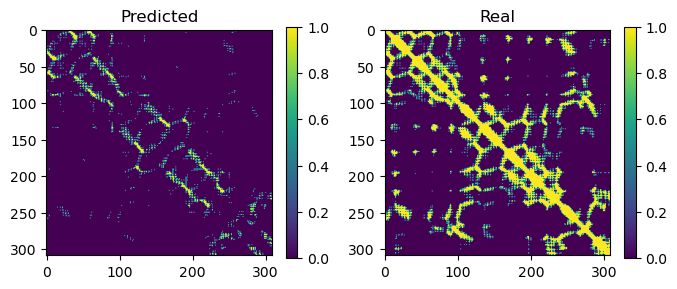

In [15]:
# # trained_model_1024_BCE 0.003 lr 6 ep
# batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
# rand_target_c = rand_target['dist'] < contact_threshold

# outputs = model(batch_tokens, return_contacts=True)

# N = len(batch_strs[0])
# fig, ax = plt.subplots(1, 2, figsize=(8, 3))
# im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
# fig.colorbar(im)
# ax[0].set_title("Predicted")
# im = ax[1].imshow(rand_target_c)
# fig.colorbar(im)
# ax[1].set_title("Real")
# plt.show()

In [ ]:
# Random example testing

rand_example = np.random.randint(len(valid_dataset))
rand_target = valid_dataset[rand_example]

print(f"Data point {rand_example}, {rand_target['seq']}")

batch_labels, batch_strs, batch_tokens = batch_converter([(rand_example, rand_target["seq"])])
rand_target_c = rand_target['dist'] < contact_threshold

outputs = model(batch_tokens, return_contacts=True)

N = len(batch_strs[0])
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = ax[0].imshow(outputs['contacts'][0].detach().numpy() > 0.5)
fig.colorbar(im)
ax[0].set_title("Predicted")
im = ax[1].imshow(rand_target_c)
fig.colorbar(im)
ax[1].set_title("Real")
plt.show()

In [21]:
#torch.save(model, 'trained_model_1024_BCE_6ep.pth')